## This script evaluate data from two testing patients. This will test the data quality of data recorded from Ruijin Hospital based on two paradigms: simplified pinyin and three-class movement.

Only Pinyin experiment for this patient (no movement experiment).

In [1]:
import copy

from speech_pinyin_Ruijin.config import *
import glob
from scipy.io import wavfile
import matplotlib.pylab as plt
import mne
import numpy as np
from utils.util_MNE import keep_annotation
import itertools

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
sid=5
folder=data_dir+str(sid)+'-*'
folder=os.path.normpath(glob.glob(folder)[0])
folder=folder.replace("\\", "/")


In [3]:
# Read EEG
file=glob.glob(os.path.join(folder,'raw','*.edf'))[0]
raw = mne.io.read_raw_edf(file,preload=True)
raw.resample(sfreq=1000)

<RawEDF | 2024-11-13{E70DE08F-08A4-4B9E-BBDB-6FAFAB7A83BD} Data.edf, 196 x 793500 (793.5 s), ~1.16 GB, data loaded>

In [13]:
# Read audio
session=1
audio_folder=folder+'/raw/matlab/'
files=['cly1113_202411131426','1113cly2_202411131432']
file=audio_folder+files[session]+'/recording.wav'
sf_audio,audio=wavfile.read(file)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_35924\2011343622.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf_audio,audio=wavfile.read(file)


In [14]:
import hdf5storage
#filename=folder+'/raw/matlab/result/pinyin_simplified/JinKeFen_202409131117/prompt_shown.mat'
filename=audio_folder+files[session]+'/prompt_shown.mat'
mat=hdf5storage.loadmat(filename)
prompt_shown=mat['prompt_shown'][0]

In [15]:
classes=[]
for i in range(len(prompt_shown)):
    tmp1=prompt_shown[i][0].split("@")
    prompt=tmp1[1]
    time=datetime.strptime(tmp1[0],'%Y-%m-%d %H:%M:%S:%f')
    if prompt=='a':
        classes.append(1)
    elif prompt=='e':
        classes.append(2)
    elif prompt=='i':
        classes.append(3)    
    elif prompt=='u':
        classes.append(4)
    elif prompt=='':
        classes.append(99)

print(len(classes))

36


In [16]:
dummy_task=[i for i in range(len(classes)) if classes[i]==99]
print(dummy_task)

[5, 11, 18, 26]


In [17]:
# pause audio recordings
trial_begins=[]
beep=[1,0,1,0,1,0]
index=0
while index<len(audio)-10:
    if all(audio[index:index+6]==beep):
        trial_begins.append(index+6)
        index=index+5*48000 # jump before step-by-step search
    index=index+1
print(len(trial_begins))

36


In [18]:
# remove the beep
audio_clean=[]
lengths=[]
for i in range(len(trial_begins)):
    if i==len(trial_begins)-1: # the last trial
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop]
    length=len(tmp)
    lengths.append(length/48000)
    audio_clean.append(tmp)
print(len(audio_clean))

36


In [10]:
audio2=[sample for sublist in audio_clean for sample in sublist]
len(audio2)/48000

266.55

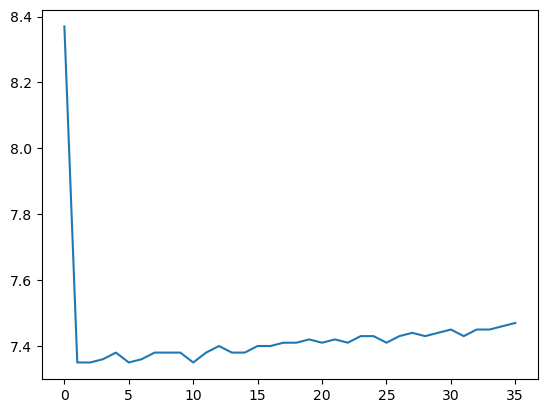

In [11]:
# save trial length
plt.plot(lengths)
filename=folder+'/processed/session'+str(session)+'_trial_length_audio'
#np.save(filename, np.array(lengths, dtype=object), allow_pickle=True)

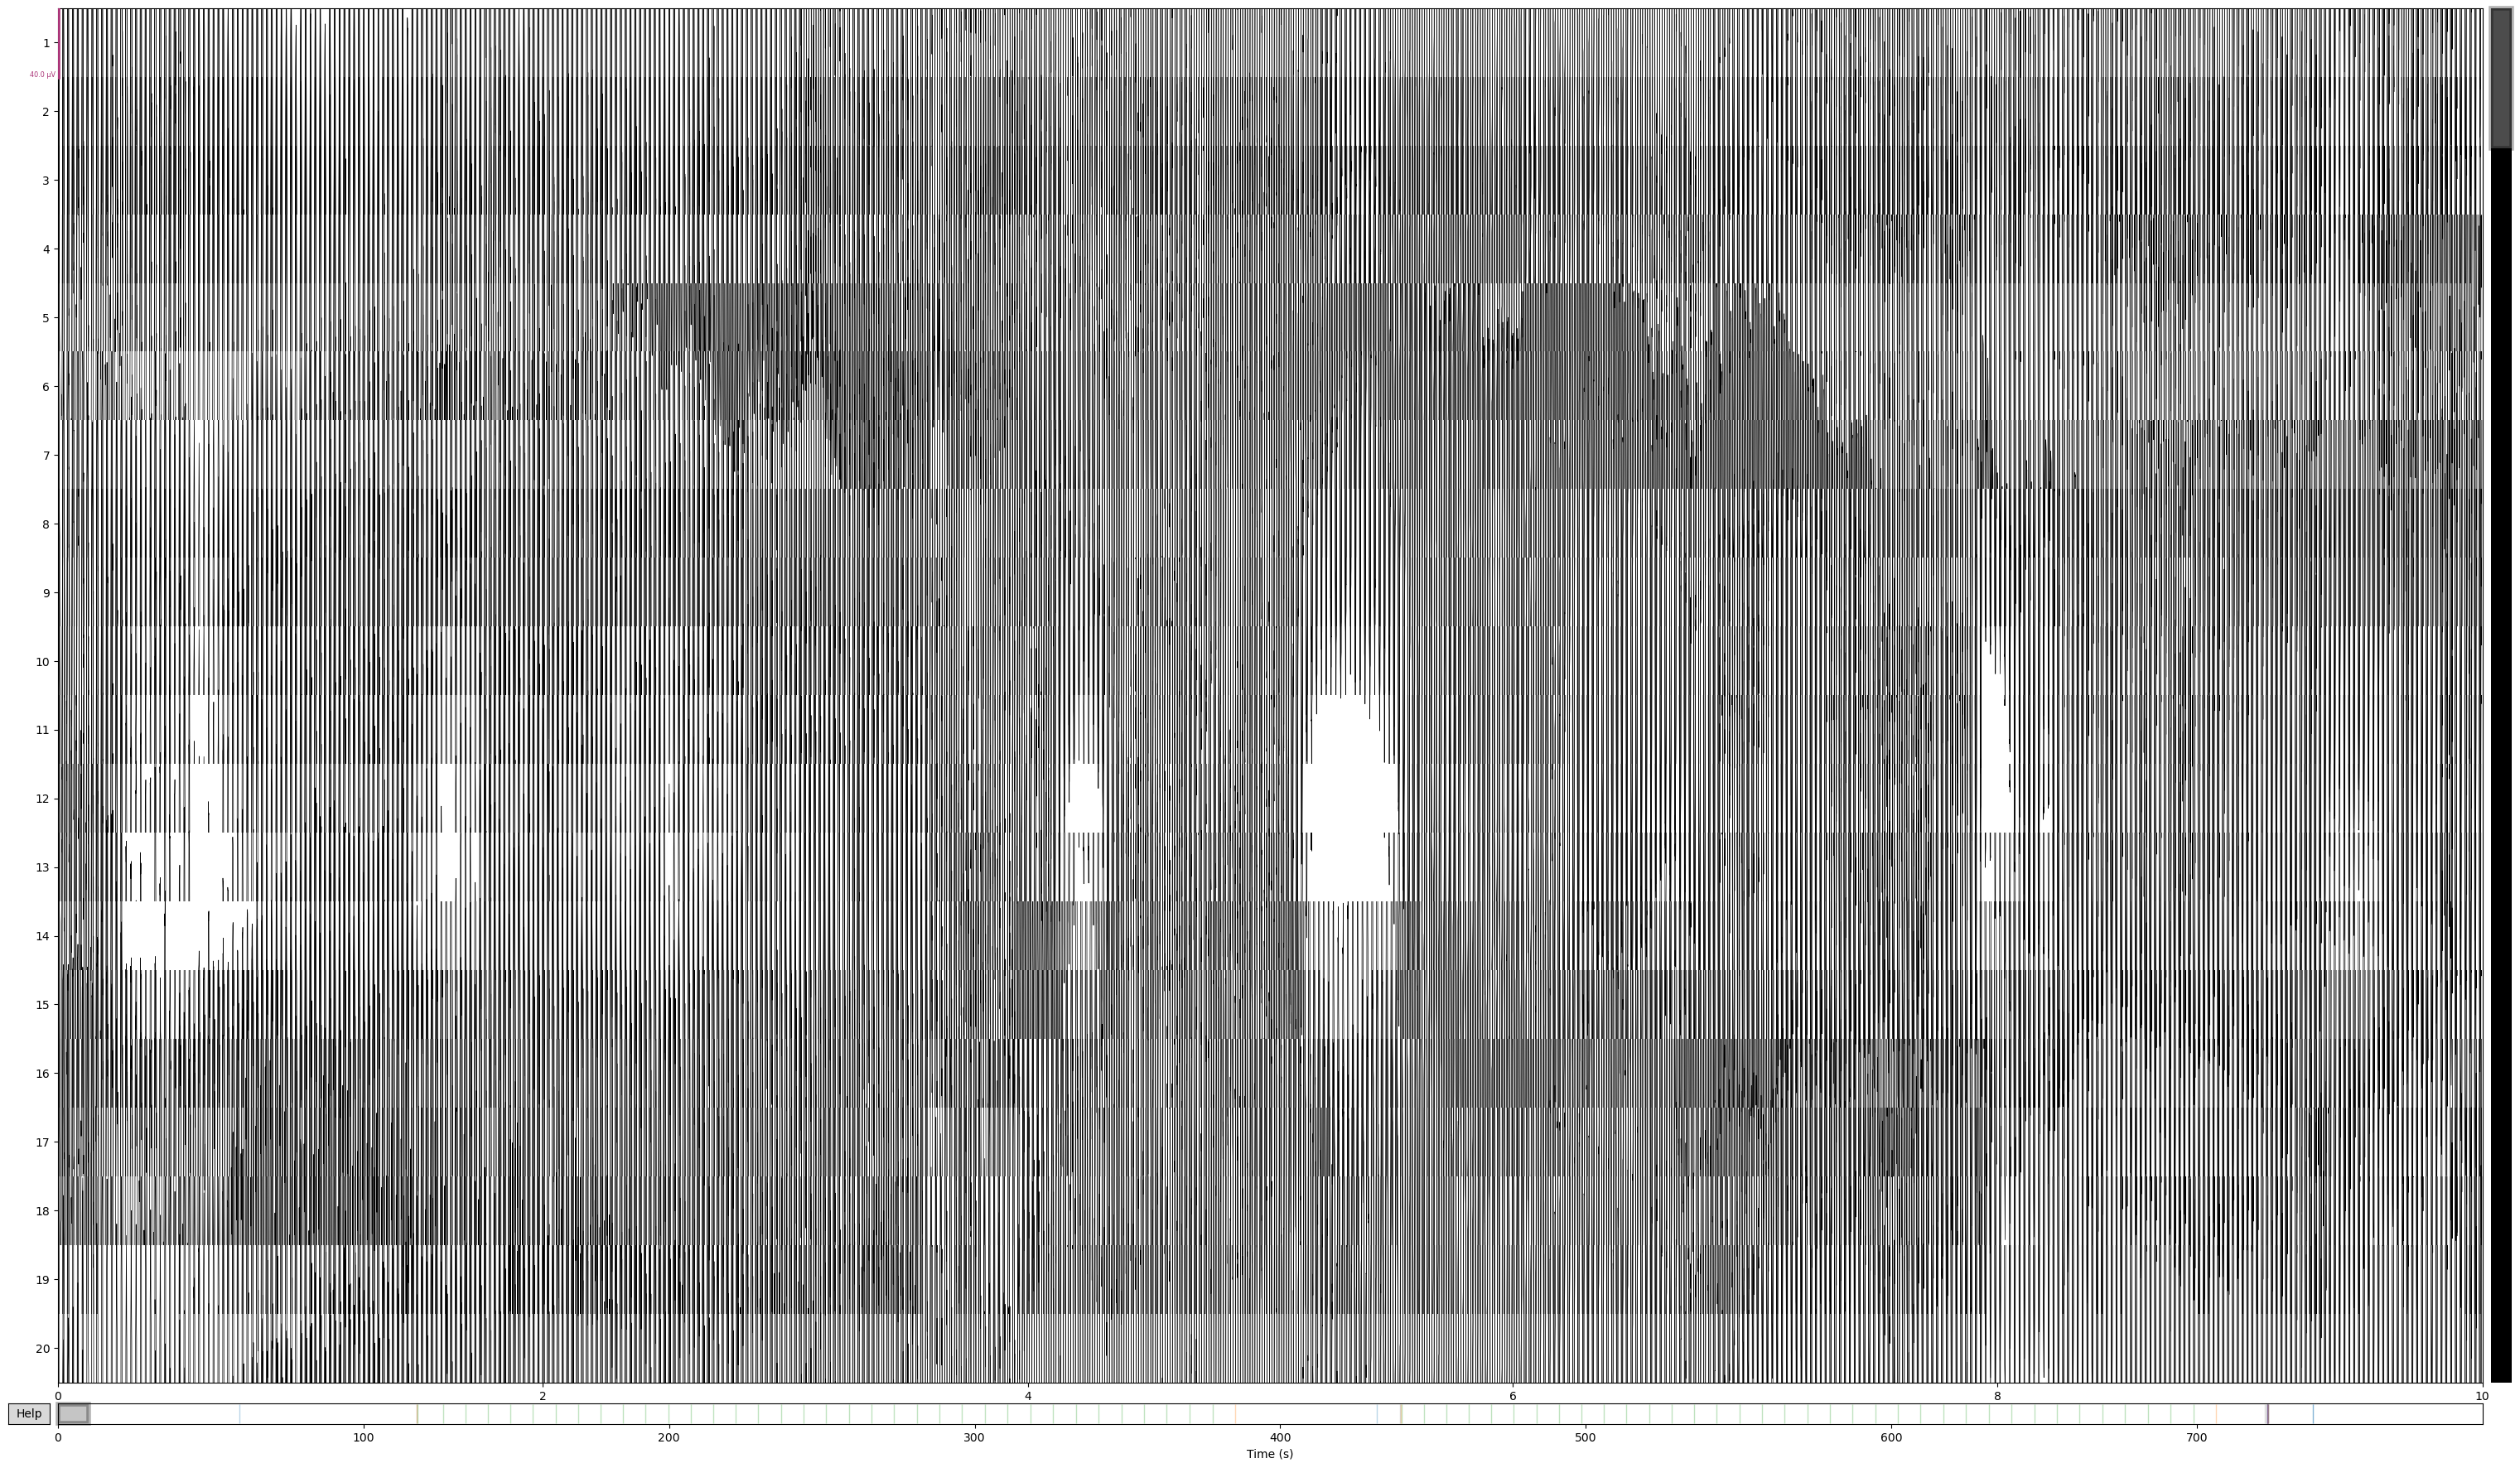

In [4]:
%matplotlib qt
raw.plot()

In [19]:
if session==0:
    raw_pinyin=raw.copy().crop(tmin=56 ,tmax=400) # first session
elif session==1:
    raw_pinyin=raw.copy().crop(tmin=414 ,tmax=712) # second session

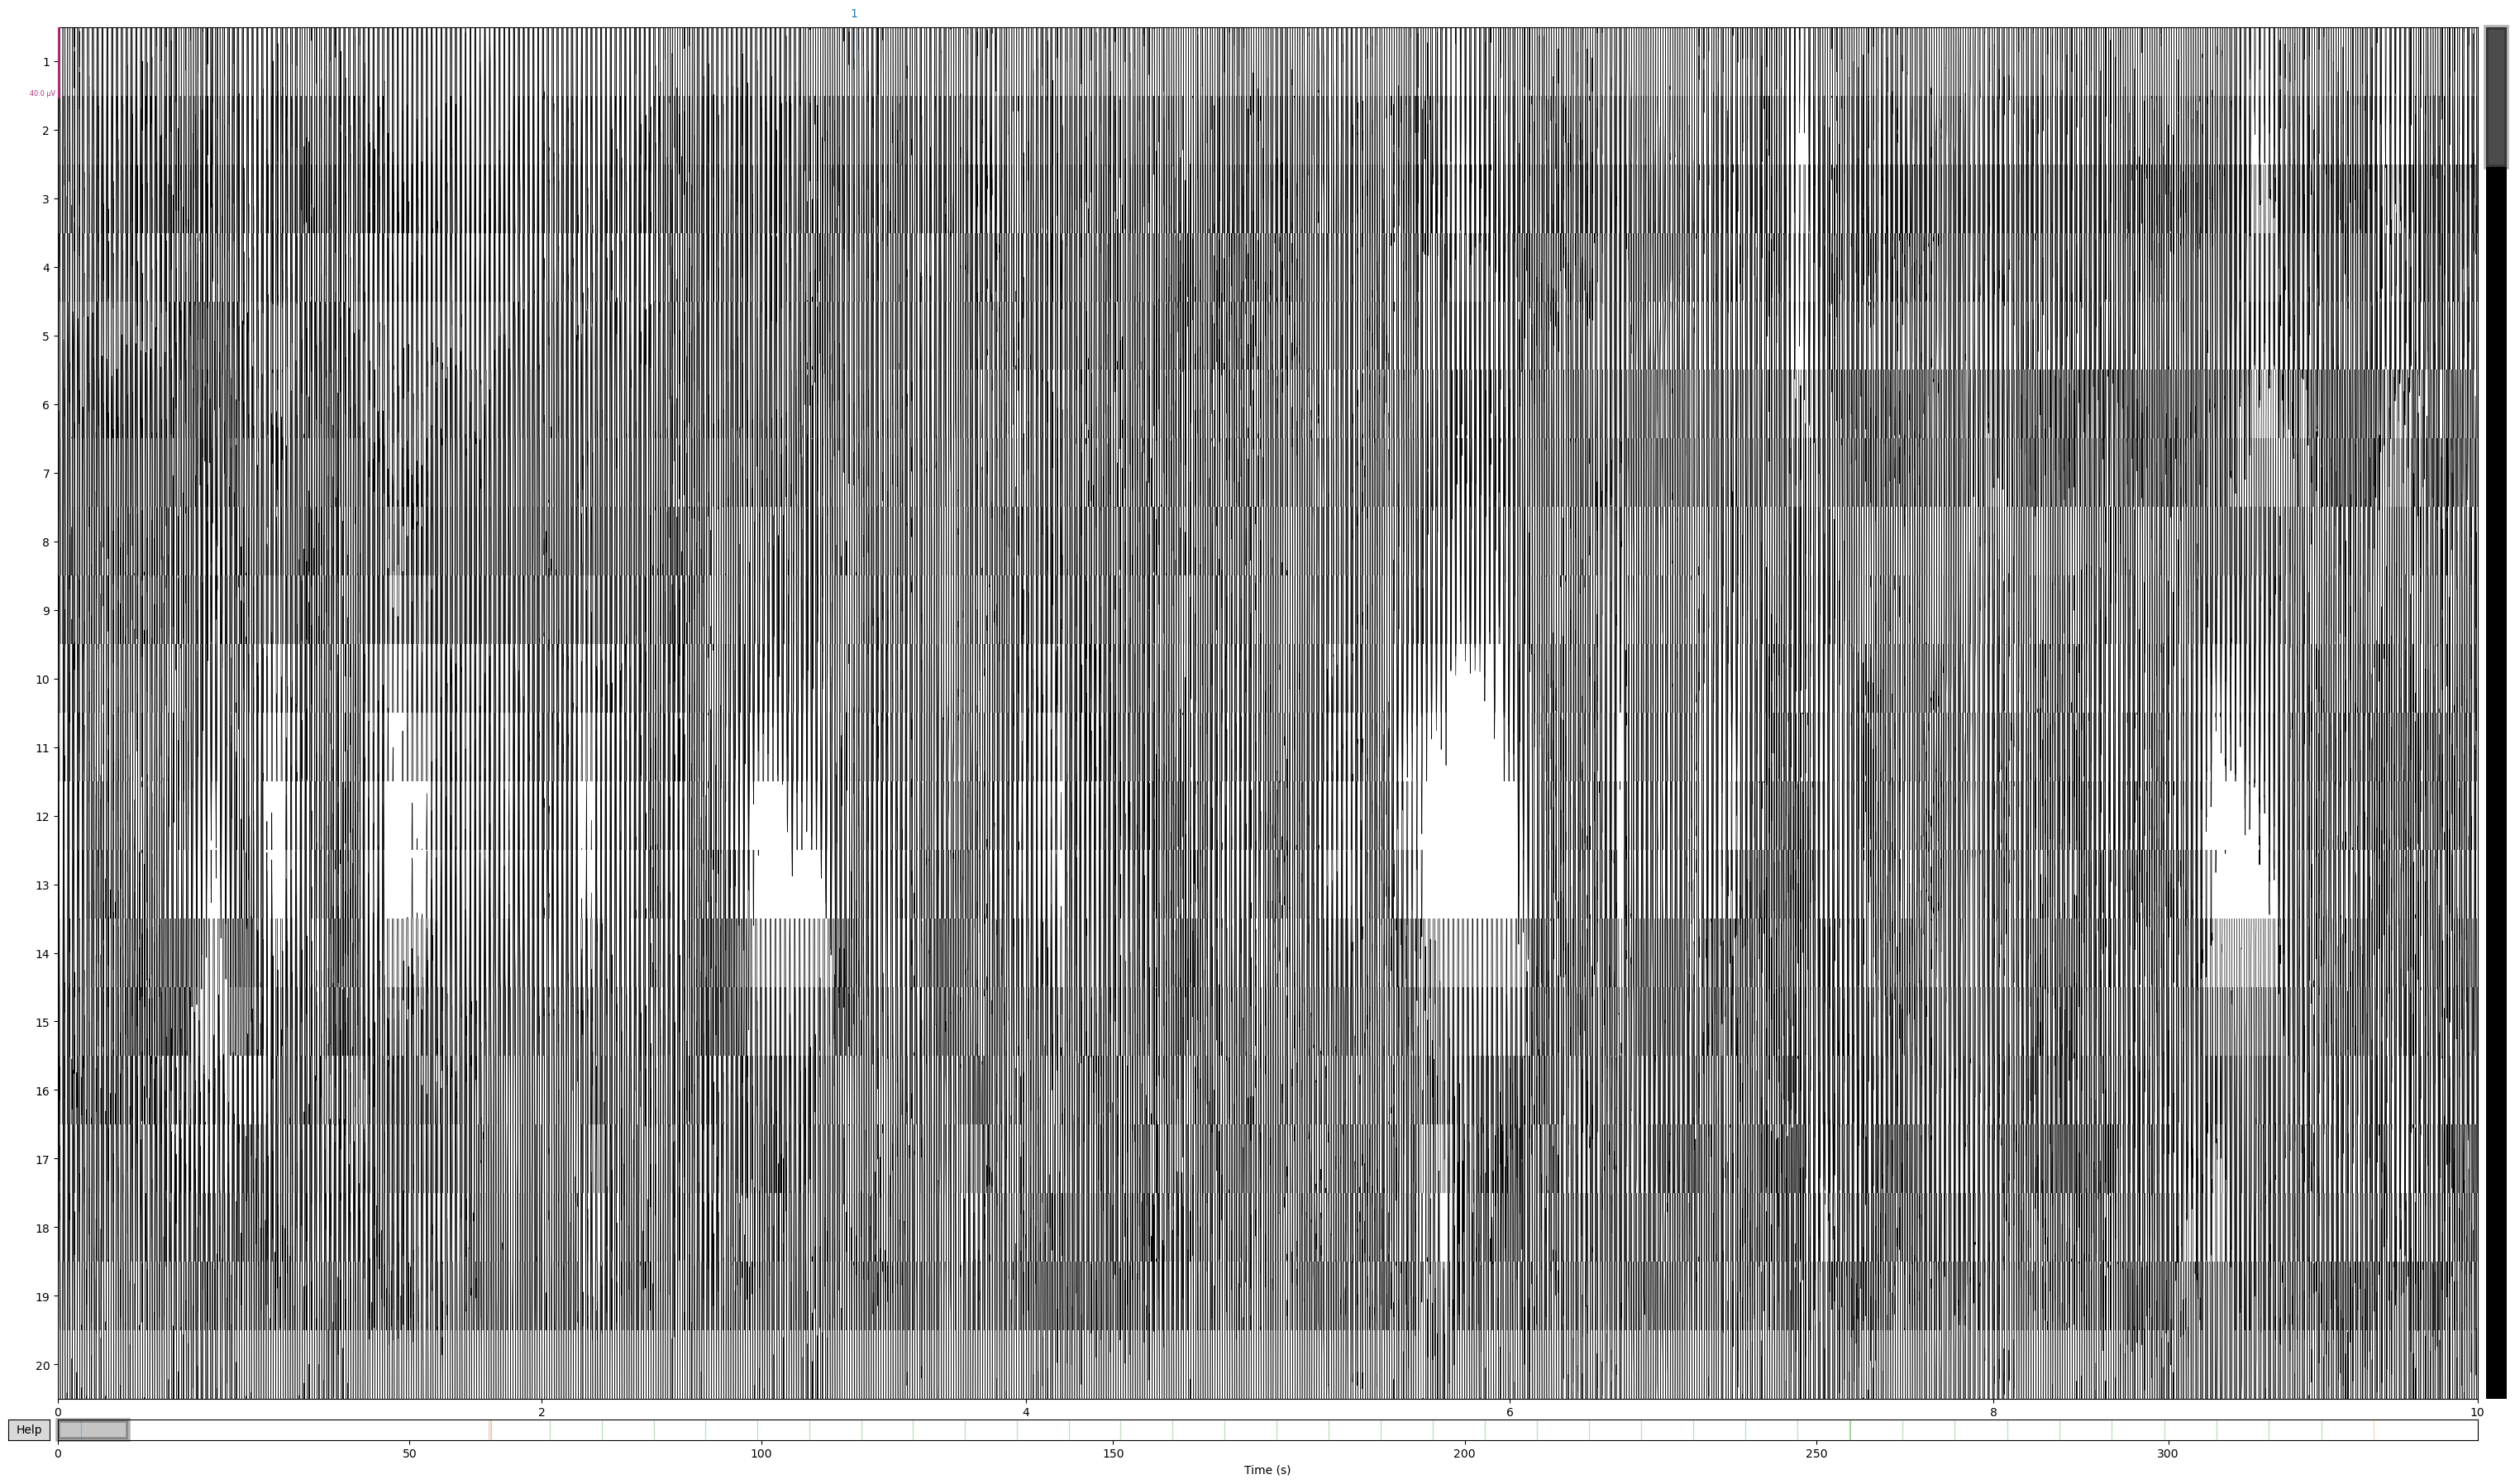

In [15]:
%matplotlib qt
raw_pinyin.plot()

In [23]:
events_tmp=mne.find_events(raw_pinyin, stim_channel='Trigger')

In [24]:
# Triggers sent by matlab is different in eeg. 1->82127; 8->110417; 10->118433; 5->98158; 2->86135;
# 91---92---93---5---5--5--94--94--5---5---5---93
import copy
events_tmp2=copy.deepcopy(events_tmp)
for i in range(events_tmp.shape[0]):
    if events_tmp[i,-1]==82127:
        events_tmp2[i,-1]=91
    elif events_tmp[i,-1]==110417:
        events_tmp2[i,-1]=92
    elif events_tmp[i,-1]==118433:
        events_tmp2[i,-1]=93
    elif events_tmp[i,-1]==98158:
        events_tmp2[i,-1]=5
    elif events_tmp[i,-1]==86135:
        events_tmp2[i,-1]=94 # pause

events=copy.deepcopy(events_tmp2)
j=0
for i in range(events_tmp2.shape[0]):
    if events_tmp2[i,-1]==5:
        #if classes[j] !=99:
        events[i,-1]=classes[j]
        j=j+1
print(str(j))

# extract task event ('5')
events_tasks=np.asarray([event for event in events if event[-1] not in [91,92,93,94]])
print(len(events_tasks)) # some of them are '99' (silent task).

36
36


In [25]:
raw_pinyin.add_events(events_tasks, "Trigger",replace=True)

In [20]:
intervals=[]
for i in range(len(events_tasks)-1):
    start=events_tasks[i,0]
    end=events_tasks[i+1,0]
    tmp=(end-start)/1000
    intervals.append(tmp)
intervals.append(7) # the last trial;

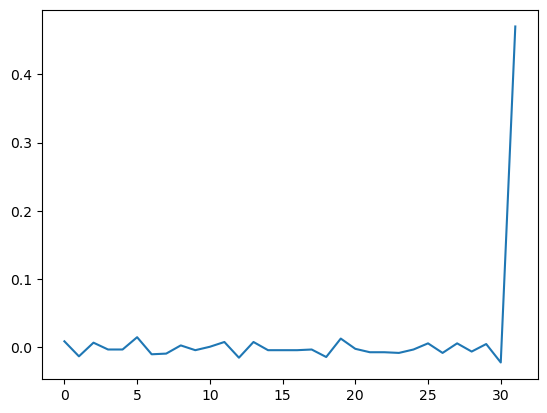

In [21]:
%matplotlib inline
lengths2=[lengths[i] for i in range(len(lengths)) if i not in dummy_task]
intervals2=[intervals[i] for i in range(len(intervals)) if i not in dummy_task]
difference=[i-j for i,j in zip(lengths2, intervals2)]
accum=np.cumsum(difference)
plt.plot(difference)

In [26]:
raw_pinyin.drop_channels(['135','136','159','160']+[str(i) for i in range(163,193)])
raw_pinyin.drop_channels(['72','ECG','LEMG','REMG'])
raw_pinyin.drop_channels(['64','102','24']) # these three channels have much higher broadband power then others;

<RawEDF | 2024-11-13{E70DE08F-08A4-4B9E-BBDB-6FAFAB7A83BD} Data.edf, 155 x 298001 (298.0 s), ~352.5 MB, data loaded>

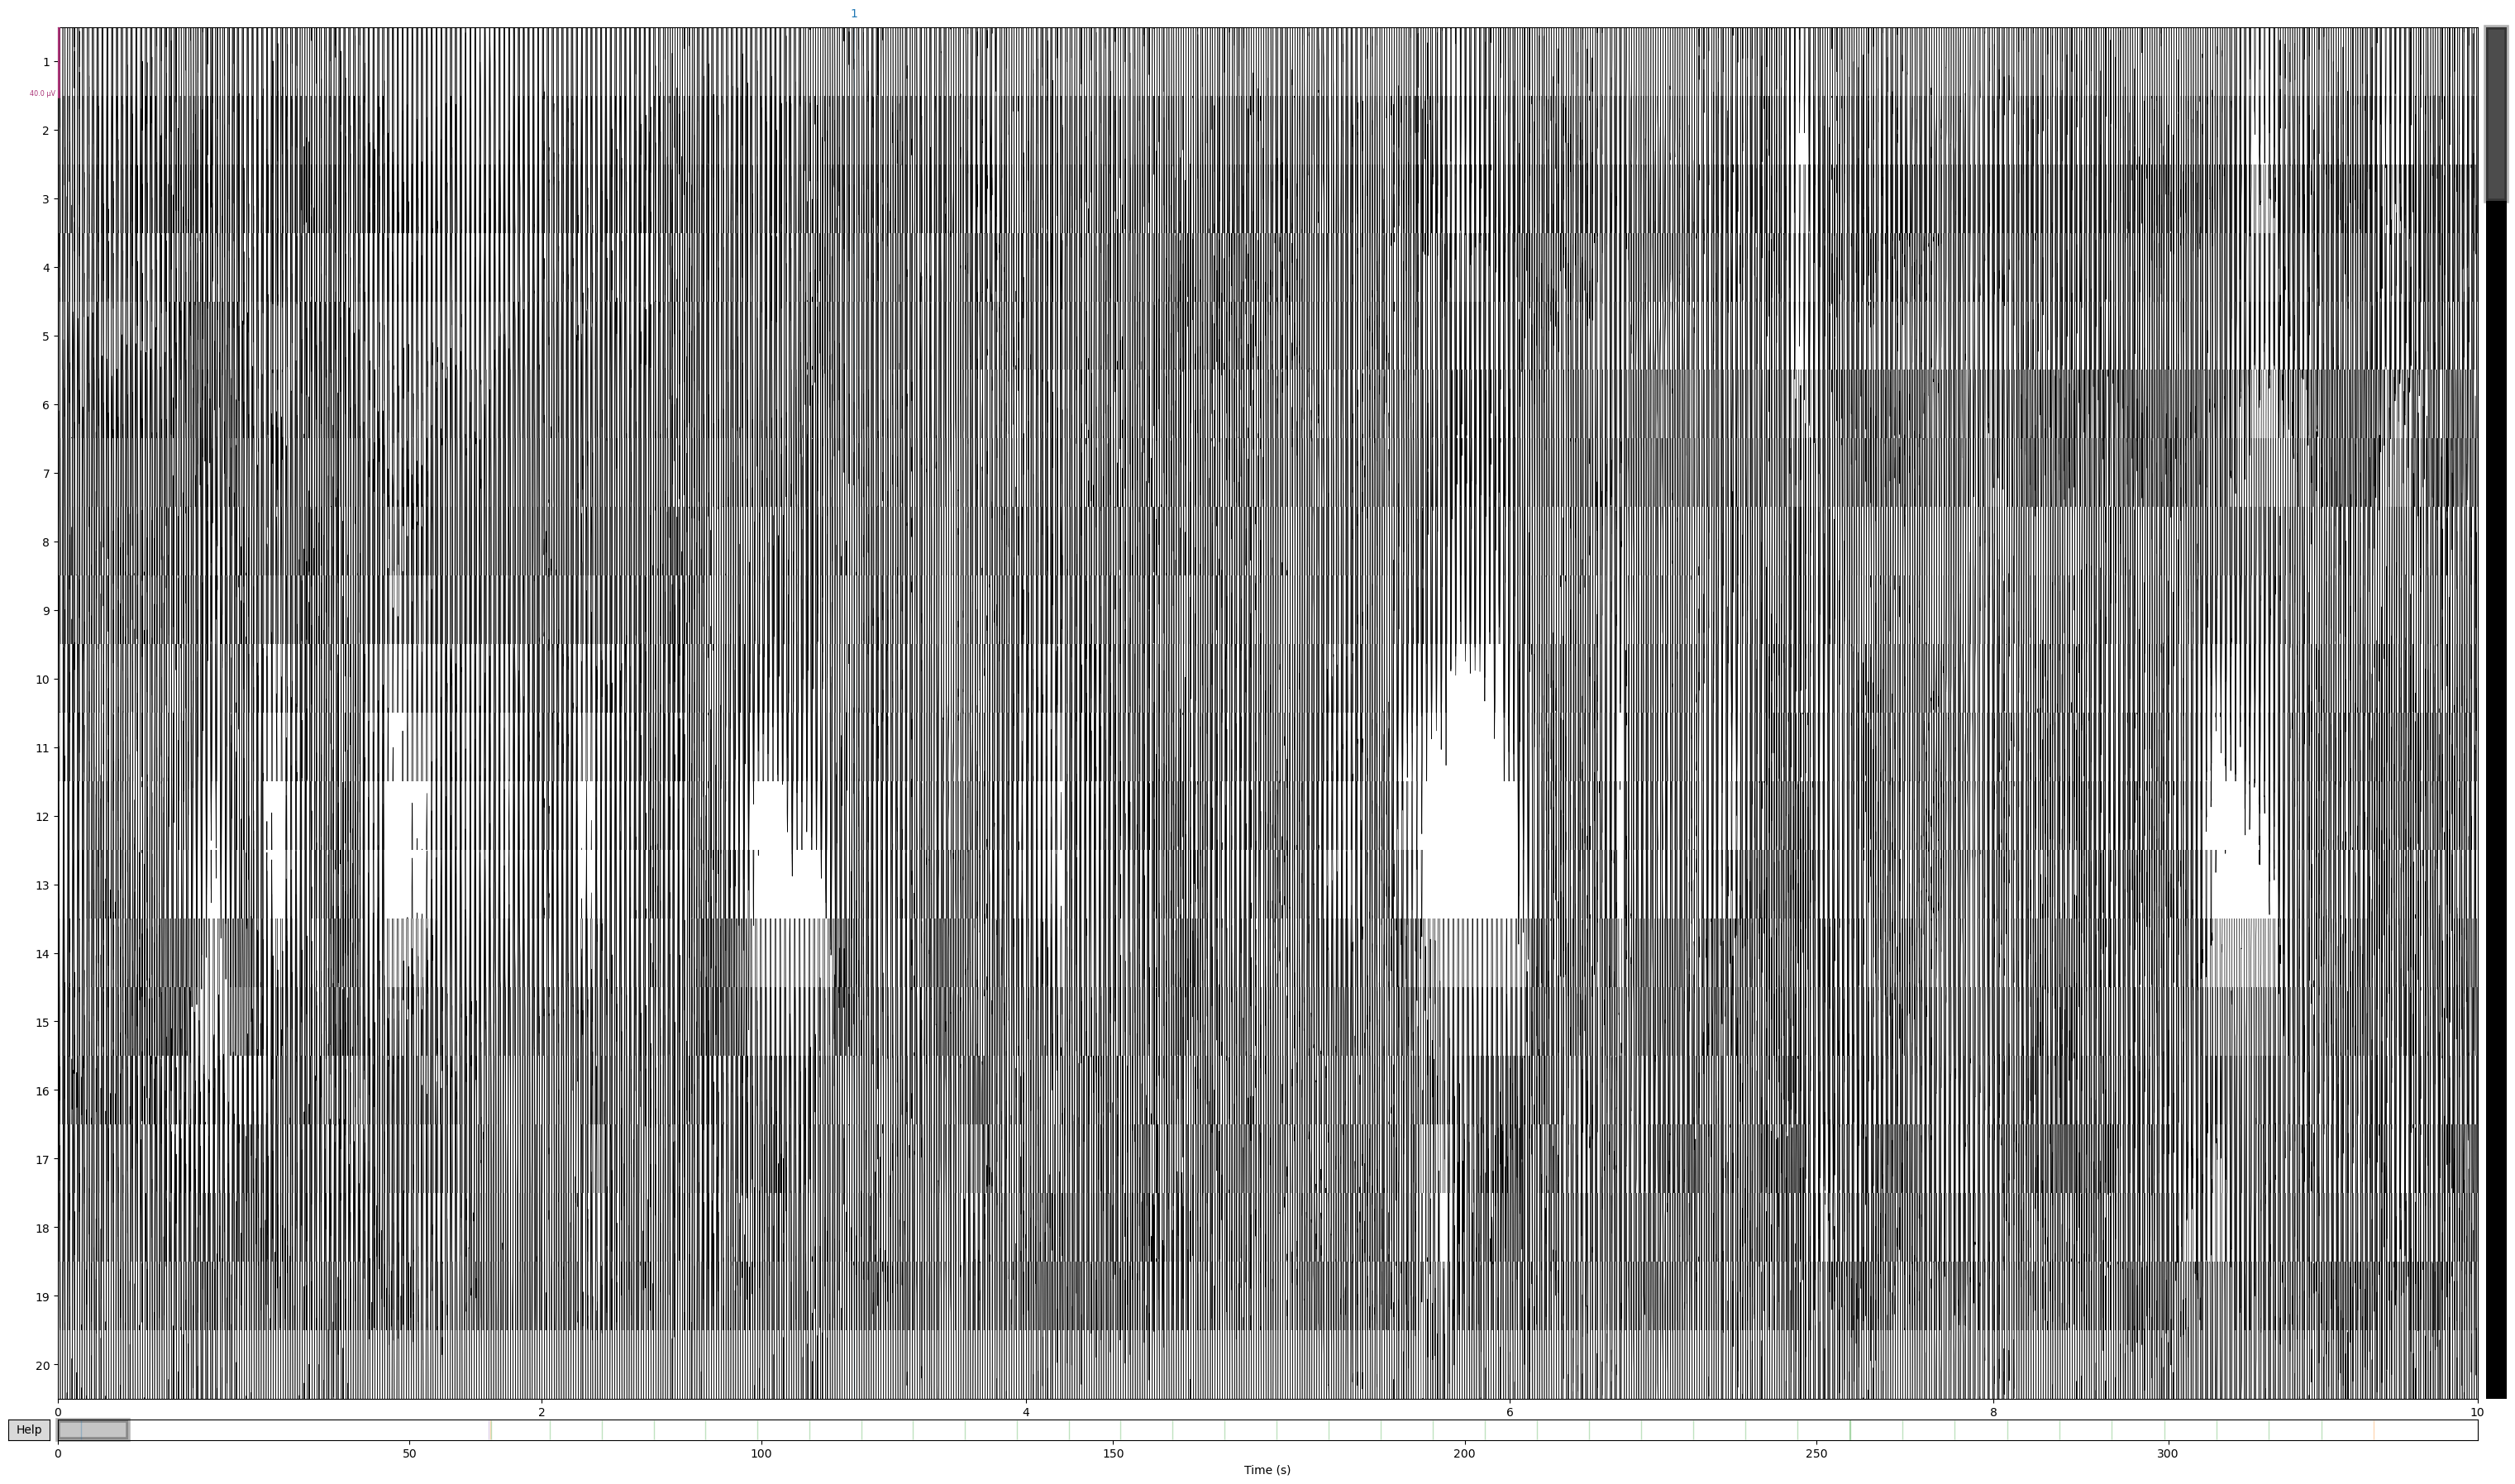

In [71]:
%matplotlib qt
raw_pinyin.plot()

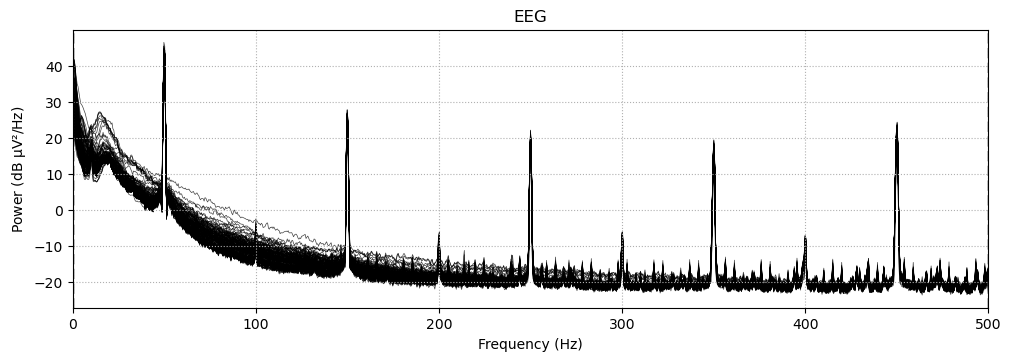

In [27]:
%matplotlib qt
raw_pinyin.compute_psd().plot() # Very strange PSD profile;

In [28]:
#raw_pinyin.filter(50,495) # test if the low decoding accuracy was caused by the wierd PSD around 10-30 Hz: the same.
raw_pinyin.filter(1,495)
frequency=np.asarray([50, 100, 150, 200, 250, 300, 350, 400, 450]) #np.arange(50, 500, 50).tolist()
notch_widths=np.asarray([3,1,3,1,3,1,3,1,3]) #np.asarray([3,]*len(frequency))
raw_pinyin.notch_filter(freqs=frequency,notch_widths=notch_widths)

<RawEDF | 2024-11-13{E70DE08F-08A4-4B9E-BBDB-6FAFAB7A83BD} Data.edf, 155 x 298001 (298.0 s), ~352.5 MB, data loaded>

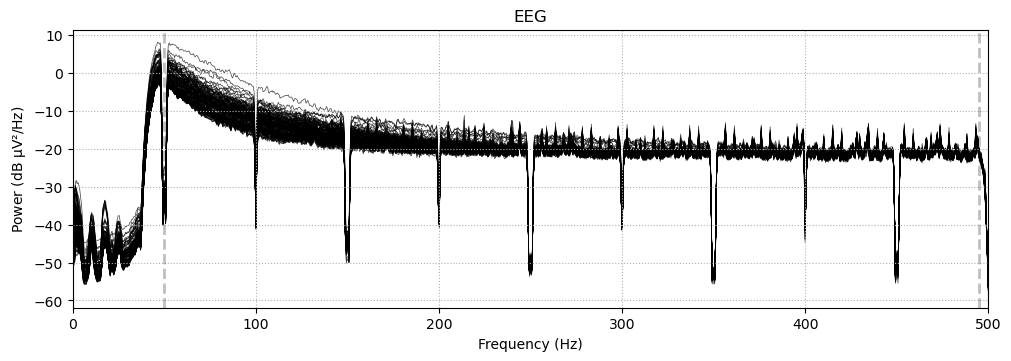

In [29]:
%matplotlib qt
raw_pinyin.compute_psd().plot() # why channel 64 is so strong?

In [30]:
filename=folder+'/processed/pinyin_'+str(session)+'.fif'
raw_pinyin.save(filename,overwrite=True)

In [97]:
test_on='pinyin'

if test_on=='pinyin':
    raw_pinyin=mne.io.read_raw_fif(filename)#('D:/data/BaiduSyncdisk/speech_pinyin/3-135/processed/pinyin.fif')
    events_tmp=mne.find_events(raw_pinyin, stim_channel='Trigger')
    tmp=[]
    for aa in events_tmp:
        if aa[-1]!=99:
            tmp.append(aa)
    events=np.asarray(tmp)
    epochs_all = mne.Epochs(raw_pinyin, events, tmin=0, tmax=7.3,baseline=None)
    
    task_id=1 # 1/2/3/4
    epochs=epochs_all[str(task_id)]
    epochs=epochs_all
elif test_on=='movement':
    raw_movement=mne.io.read_raw_fif('D:/data/BaiduSyncdisk/speech_pinyin/3-135/processed/movement.fif')
    events=mne.find_events(raw_movement, stim_channel='Trigger')
    epochs_all = mne.Epochs(raw_movement, events, tmin=0, tmax=10,baseline=None)
    
    task_id=1
    #epochs=epochs_all[str(task_id)]
    epochs=epochs_all

In [101]:
decim=4
new_fs=1000/decim
n_cycles_mthod='stage' # or: equal
vmin=-4
vmax=4
fMin,fMax=2,150
fstep=1
freqs=np.arange(fMin,fMax,fstep) #148
fNum=freqs.shape[0]
#freqs = np.linspace(fMin,fMax, num=fNum)
cycleMin,cycleMax=8,50
cycleNum=fNum
#n_cycles = np.linspace(cycleMin,cycleMax, num=cycleNum)  # different number of cycle per frequency
groups=5
rates=[2,2.5,3,4,5]
num_per_group=int(fNum/groups)
if n_cycles_mthod=='equal':
    n_cycles=freqs
elif n_cycles_mthod=='stage':
    n_cycles=[]
    for g in range(groups):
        if g < groups -1:
            tmp=[int(i) for i in freqs[g*num_per_group:(g+1)*num_per_group]/rates[g]]
        elif g==groups -1:
            tmp = [int(i) for i in freqs[g * num_per_group:] / rates[g]]
        n_cycles.extend(tmp)

In [107]:
# better than the above MNE method.
%matplotlib inline
from mne.time_frequency import tfr_morlet
if test_on=='pinyin':
    baseline = [int(0*new_fs), int(3*new_fs)]
elif test_on=='movement':
    baseline = [int(0*new_fs), int(5*new_fs)]
ch_names=epochs.ch_names
chnNum=len(ch_names)
chid=0
for chid in range(chnNum-1):
    fig,ax=plt.subplots()
    chname=epochs.ch_names[chid]
    # The very big artifact at begainning and end of the TF will cause ERS vanish after normalization.
    ch_power=np.squeeze(tfr_morlet(epochs, picks=[chname], freqs=freqs, n_cycles=n_cycles,use_fft=True,return_itc=False, 
                                   average=True, decim=decim, n_jobs=1).data) # (148, 1251) (frequency, time)

    base = ch_power[:, baseline[0]:baseline[1]] #  (148, 175)
    basemean = np.mean(base, 1) # (148)
    basestd= np.std(base, 1) #(148) 
    #ch_power_norm = 10*np.log10(ch_power / basemean[:, :, None]) #
    ch_power_norm=(ch_power-basemean[:,None])/basestd[:,None]
    ax.imshow(ch_power_norm,origin='lower', cmap='RdBu_r',vmin=vmin, vmax=vmax) # same as below
    ax.set_aspect('auto')
    filename=folder+'/processed/tf_result_pinyin_1task/ch_'+str(chid)+'.png'
    fig.savefig(filename, dpi=400)
    fig.clear()
    plt.close(fig)

The best plot:

![](img\16.png)